# Parallel Beam Tomographic Reconstruction using Simple Backprojection


In [28]:
import numpy as np

from scipy.interpolate import interp1d, griddata
from scipy.constants import golden_ratio
from scipy.fft import fft, ifft, fftfreq, fftshift, fft2, ifft2
from warnings import warn
from functools import partial

from scipy.interpolate import interp1d 

from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import glob
import pydicom as dicom

from skimage.transform import radon
from skimage.transform import iradon

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

(512, 512) (512, 180)
(512, 512) (512, 512)


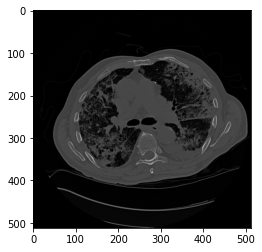

MSE: 0.17347381359175937
PSNR: 7.607660740196325


In [34]:
def simple_backprojection(radon_transform, theta=None, output_size=256 ):
    # radon_transform: pass as input, the radon transform of the desired image, it has the shape (number of detectors, number of projections)
    # theta: Number of projections taken while obtaining the radon transform, for instance, if 984 projections are taken while covering an angle from 0 to 2pi, theta will be: np.linspace(0, 360, 984, endpoint=False)

    if theta is None:
        theta = np.linspace(0, 180, radon_transform.shape[1], endpoint=False)

    # store number of projections in the variable: angles_count
    # HERE    
    angles_count = theta.shape[0]
    interpolation = 'linear'
    
    # convert radon_image to np.float32
    # HERE    
    radon_image = radon_transform.astype(np.float32)

    #######################################################
    dtype = radon_image.dtype

    img_shape = radon_transform.shape[0]


    if output_size is None:
        # If output size not specified, estimate from input radon image
        output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))
    #######################################################

    # Reconstruct image by interpolation
    # create a variable reconstructed of size output_size x output_size with the same dtype as the radon_transform and initialize all values in it to zero
    # HERE    
    reconstructed = np.zeros((output_size, output_size),dtype=dtype)


    ##### Here we create a grid, your job is to backproject the radon transform on this grid #####
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    ### Backprojection ###
    # each column in the radon transform represents a projection along a given angle theta
    # the number of rays in each such projection is equal to the number of dectors (first dimension of radon_transform) 
    # for each projection, you have the ray sum along each detector -> 1 point in the radon transform, 
    # you have to backproject this point on a cartesian grid so we can see the reconstructed image

    # the grid has been made for you, it is stored in the variables xpr and ypr  
    # representing the x and y coordinates of each point in the grid

    # iterate over each column in the radon transform and backproject it on the grid
    # use interpolation to obtain values corresponding to EXACT points on the grid

    # After obtaining the interpolated points, simply add them to the reconstructed variable created earlier
    for col, angle in zip(radon_image.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(x, col, kind=interpolation,
            bounds_error=False, fill_value=0)
        reconstructed += interpolant(t)

    
    return reconstructed * np.pi / (2 * angles_count)

## load the input and store in a variable named inp
# HERE

for f in sorted(glob.glob("../data/ct_covid_lung/CT-7358-0014.dcm")):
    x = dicom.dcmread(f)
    dataset = x

## load the radon transform of the input and store in a variable named radon_transform
# HERE
# print(dataset)
inp = dataset.pixel_array
radon_transfor = radon(inp)
print(inp.shape,radon_transfor.shape)

# call the function simple_backprojection with the appropriate parameters and store the output in a variable named out
# HERE
out = simple_backprojection(radon_transfor,output_size=inp.shape[0])
# out = iradon(radon_transfor)
#### This is just for visualization and scoring, you don't have to do anything here ####
# normalize both
inp = inp.astype(np.float32)
inp = (inp - inp.min()) / (inp.max() - inp.min())
out = (out - out.min()) / (out.max() - out.min())
print(out.shape,out.shape)
plt.imshow(inp, cmap='gray')
plt.show()
print(f"MSE: {mean_squared_error(inp, out)}")
print(f"PSNR: {peak_signal_noise_ratio(inp, out)}")